In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX, MVNormal, MVNormalRW, Linear, CFlow
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky

np.random.seed(1234)

In [2]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100

In [3]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.21742282 0.16835931 0.01139835]


In [4]:
xs = data

In [5]:
n = data.shape[1]
s1 = 0.01
s0 = 2.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     lowerd = DFlow([Linear(dim=k*(k-1)//2 + k, name='lowerd_flow')])
#     ldiag = DFlow([NVPFlow(dim=k, name='lowerd_flow_' + str(i)) for i in range(4)])
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior', 
#                    lowerd=lowerd.output[0], ldiag=ldiag.output[0]+np.log(1/s1))
PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')

In [6]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=False):
        
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([NVPFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(6)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 20, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'param_walk_prior_2/logdens/add:0' shape=() dtype=float64>

In [13]:
def create_loglik2():
    obs_d = Normal(dim=None, sigma=1., mu=0)
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_1:0' shape=() dtype=float64>

In [17]:
# df = dim[0]*dim[1]*10
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [18]:
loss = -logl - prior + ent# - cov_prior.log_prob(PWalk.fsigma) + lowerd.logdens + ldiag.logdens
loss /= n*dim[0]*dim[1]

In [19]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [20]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [21]:
sess = tf.InteractiveSession()

In [21]:
tf.global_variables_initializer().run()

In [24]:
prior.eval(), ent.eval(), logl.eval()

(641.4445557195643, 641.2782404632507, -62.59286091675813)

In [25]:
loss.eval()

0.2820222482431982

In [26]:
np.set_printoptions(precision=4)

In [27]:
PWalk.inverse_sigma.eval()[:3,:3]

array([[ 2.6812e+03,  1.4249e+00, -7.6817e-01],
       [ 1.4249e+00,  2.6559e+03,  1.0384e+00],
       [-7.6817e-01,  1.0384e+00,  2.7626e+03]])

In [28]:
all_sum = tf.summary.merge_all()
writer = tf.summary.FileWriter('/tmp/tfdbg')

In [97]:
%%time
for _ in range(50000):
    for _ in range(400):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)
    print(PWalk.inverse_sigma.eval()[:3,:3])
    print('\n')
    writer.add_summary(all_sum.eval())

0.2886755881123643
[[9.5075e+02 5.9803e-01 3.0253e-01]
 [5.9803e-01 1.0406e+03 5.4940e-01]
 [3.0253e-01 5.4940e-01 9.3463e+02]]


0.28866886644167994
[[9.4244e+02 7.2482e-01 3.0232e-01]
 [7.2482e-01 1.0429e+03 5.7662e-01]
 [3.0232e-01 5.7662e-01 9.3479e+02]]


0.2898640097507676
[[9.4975e+02 7.6457e-01 3.3639e-01]
 [7.6457e-01 1.0387e+03 5.5905e-01]
 [3.3639e-01 5.5905e-01 9.3642e+02]]


0.2870847229618159
[[9.4846e+02 7.4334e-01 3.2624e-01]
 [7.4334e-01 1.0390e+03 5.7275e-01]
 [3.2624e-01 5.7275e-01 9.3389e+02]]


0.28247966332441954
[[9.4569e+02 7.7806e-01 2.2817e-01]
 [7.7806e-01 1.0424e+03 5.4068e-01]
 [2.2817e-01 5.4068e-01 9.3433e+02]]


0.2901777858656485
[[9.4783e+02 8.0447e-01 2.8139e-01]
 [8.0447e-01 1.0420e+03 6.1972e-01]
 [2.8139e-01 6.1972e-01 9.3156e+02]]


0.2887523385810944
[[9.4346e+02 7.2126e-01 2.6443e-01]
 [7.2126e-01 1.0419e+03 6.6311e-01]
 [2.6443e-01 6.6311e-01 9.3350e+02]]


0.281454159361859
[[9.4847e+02 6.7946e-01 2.5299e-01]
 [6.7946e-01 1.0415e+03 8.7577e-01

0.2844778674012635
[[9.3400e+02 7.8822e-01 2.2032e-01]
 [7.8822e-01 1.0312e+03 2.5934e-01]
 [2.2032e-01 2.5934e-01 9.1810e+02]]


0.2813866341987302
[[9.3461e+02 8.0997e-01 1.6399e-01]
 [8.0997e-01 1.0311e+03 2.5502e-01]
 [1.6399e-01 2.5502e-01 9.1543e+02]]


0.28532248323816206
[[9.3406e+02 8.3448e-01 1.8982e-01]
 [8.3448e-01 1.0299e+03 1.7435e-01]
 [1.8982e-01 1.7435e-01 9.1507e+02]]


0.2877213001477763
[[9.3275e+02 6.0219e-01 1.6811e-01]
 [6.0219e-01 1.0322e+03 1.0761e-01]
 [1.6811e-01 1.0761e-01 9.1628e+02]]


0.28608632335919615
[[9.3366e+02 5.9025e-01 1.2587e-01]
 [5.9025e-01 1.0299e+03 6.8429e-02]
 [1.2587e-01 6.8429e-02 9.1709e+02]]


0.28471874672076986
[[9.3173e+02 5.2221e-01 1.1724e-01]
 [5.2221e-01 1.0299e+03 5.3616e-02]
 [1.1724e-01 5.3616e-02 9.1601e+02]]


0.27639399724642144
[[9.3594e+02 4.5412e-01 1.8235e-01]
 [4.5412e-01 1.0297e+03 8.9188e-03]
 [1.8235e-01 8.9188e-03 9.1256e+02]]


0.2878779288923456
[[ 9.3533e+02  5.0095e-01  2.2169e-01]
 [ 5.0095e-01  1.0322e+03 -1

0.28607253164059
[[ 9.2759e+02  4.7140e-01  8.4900e-01]
 [ 4.7140e-01  1.0229e+03 -6.0410e-02]
 [ 8.4900e-01 -6.0410e-02  9.0520e+02]]


0.2811378939605092
[[ 9.2930e+02  4.5369e-01  8.1985e-01]
 [ 4.5369e-01  1.0233e+03 -1.3389e-02]
 [ 8.1985e-01 -1.3389e-02  9.0796e+02]]


0.2836510027244261
[[ 9.2647e+02  4.6241e-01  8.0171e-01]
 [ 4.6241e-01  1.0255e+03 -6.7271e-02]
 [ 8.0171e-01 -6.7271e-02  9.1016e+02]]


0.2779982640839386
[[ 9.2890e+02  5.2376e-01  8.0536e-01]
 [ 5.2376e-01  1.0266e+03 -1.2145e-01]
 [ 8.0536e-01 -1.2145e-01  9.0622e+02]]


0.2797600185573325
[[ 9.2586e+02  4.7209e-01  8.4198e-01]
 [ 4.7209e-01  1.0195e+03 -3.2805e-03]
 [ 8.4198e-01 -3.2805e-03  9.0512e+02]]


0.27226003214135847
[[9.2446e+02 4.3432e-01 8.0193e-01]
 [4.3432e-01 1.0242e+03 9.6618e-03]
 [8.0193e-01 9.6618e-03 9.0846e+02]]


0.2863812316266897
[[ 9.2595e+02  4.0621e-01  7.4754e-01]
 [ 4.0621e-01  1.0258e+03 -9.3819e-04]
 [ 7.4754e-01 -9.3819e-04  9.1084e+02]]


0.2845261190170881
[[ 9.2436e+02  5.0

0.27597909388403274
[[9.1827e+02 4.4563e-01 2.5733e-01]
 [4.4563e-01 1.0171e+03 2.5239e-01]
 [2.5733e-01 2.5239e-01 8.9729e+02]]


0.28503889325137594
[[9.1680e+02 5.8384e-01 2.4660e-01]
 [5.8384e-01 1.0158e+03 3.7091e-01]
 [2.4660e-01 3.7091e-01 8.9692e+02]]


0.27920880187110175
[[9.1492e+02 5.8288e-01 2.8224e-01]
 [5.8288e-01 1.0210e+03 2.8271e-01]
 [2.8224e-01 2.8271e-01 8.9735e+02]]


0.2764838172027936
[[9.1450e+02 6.2068e-01 2.9115e-01]
 [6.2068e-01 1.0186e+03 2.5783e-01]
 [2.9115e-01 2.5783e-01 8.9526e+02]]


0.2809501161110835
[[9.0892e+02 6.5106e-01 2.8633e-01]
 [6.5106e-01 1.0187e+03 2.7866e-01]
 [2.8633e-01 2.7866e-01 8.9409e+02]]


0.28387762145868056
[[9.1336e+02 6.4547e-01 3.3102e-01]
 [6.4547e-01 1.0169e+03 2.8860e-01]
 [3.3102e-01 2.8860e-01 8.9515e+02]]


0.29637625510357474
[[9.1266e+02 6.4985e-01 3.4210e-01]
 [6.4985e-01 1.0164e+03 2.1484e-01]
 [3.4210e-01 2.1484e-01 8.9283e+02]]


0.2785408197347427
[[9.1527e+02 6.5688e-01 3.4690e-01]
 [6.5688e-01 1.0147e+03 2.5805

0.2924578583801915
[[ 9.0950e+02  4.5516e-02  5.8191e-01]
 [ 4.5516e-02  1.0129e+03 -3.0711e-01]
 [ 5.8191e-01 -3.0711e-01  8.8251e+02]]


0.2958960505567875
[[ 9.0715e+02  1.5867e-01  5.8014e-01]
 [ 1.5867e-01  1.0128e+03 -3.5896e-01]
 [ 5.8014e-01 -3.5896e-01  8.8171e+02]]


0.2791509177928683
[[ 9.0569e+02  1.4297e-01  5.2228e-01]
 [ 1.4297e-01  1.0092e+03 -3.7906e-01]
 [ 5.2228e-01 -3.7906e-01  8.8367e+02]]


0.27745899096004933
[[ 9.1039e+02  2.2120e-01  5.9560e-01]
 [ 2.2120e-01  1.0101e+03 -4.6068e-01]
 [ 5.9560e-01 -4.6068e-01  8.8350e+02]]


0.2864187845946245
[[ 9.0847e+02  1.7721e-01  5.3917e-01]
 [ 1.7721e-01  1.0115e+03 -5.5046e-01]
 [ 5.3917e-01 -5.5046e-01  8.8357e+02]]


0.2775256398459478
[[ 9.0857e+02  1.8371e-01  5.4289e-01]
 [ 1.8371e-01  1.0136e+03 -5.2386e-01]
 [ 5.4289e-01 -5.2386e-01  8.7724e+02]]


0.27981728610690315
[[ 9.0936e+02  1.7425e-01  5.5316e-01]
 [ 1.7425e-01  1.0121e+03 -4.0799e-01]
 [ 5.5316e-01 -4.0799e-01  8.8059e+02]]


0.2815748296070154
[[ 9.0

0.2923534499857498
[[ 9.0559e+02 -1.5737e-01  3.6882e-01]
 [-1.5737e-01  1.0075e+03 -1.3535e+00]
 [ 3.6882e-01 -1.3535e+00  8.7016e+02]]


0.2769822694715091
[[ 9.0485e+02 -2.0122e-01  5.6382e-01]
 [-2.0122e-01  1.0087e+03 -1.1759e+00]
 [ 5.6382e-01 -1.1759e+00  8.6773e+02]]


0.2832431208997382
[[ 9.0193e+02 -2.0481e-01  5.4046e-01]
 [-2.0481e-01  1.0047e+03 -1.2471e+00]
 [ 5.4046e-01 -1.2471e+00  8.6608e+02]]


0.2789667361381684
[[ 9.0155e+02 -1.9306e-01  5.2208e-01]
 [-1.9306e-01  1.0075e+03 -1.1460e+00]
 [ 5.2208e-01 -1.1460e+00  8.6749e+02]]


0.28341849876388897
[[ 9.0163e+02 -2.7679e-01  4.7852e-01]
 [-2.7679e-01  1.0120e+03 -1.1926e+00]
 [ 4.7852e-01 -1.1926e+00  8.6953e+02]]


0.28463904389000566
[[ 8.9818e+02 -2.1742e-01  5.0692e-01]
 [-2.1742e-01  1.0087e+03 -1.1644e+00]
 [ 5.0692e-01 -1.1644e+00  8.7297e+02]]


0.2894465243325006
[[ 9.0192e+02 -2.3917e-01  6.0685e-01]
 [-2.3917e-01  1.0051e+03 -1.1916e+00]
 [ 6.0685e-01 -1.1916e+00  8.6854e+02]]


0.27884352862332046
[[ 9.

0.2890097913868784
[[ 8.9219e+02  2.9139e-01  1.1648e+00]
 [ 2.9139e-01  1.0044e+03 -9.5773e-01]
 [ 1.1648e+00 -9.5773e-01  8.6520e+02]]


0.29018536927481786
[[ 8.9891e+02  3.0253e-01  1.1719e+00]
 [ 3.0253e-01  1.0064e+03 -9.5126e-01]
 [ 1.1719e+00 -9.5126e-01  8.6236e+02]]


0.274746516957043
[[ 8.9571e+02  2.8943e-01  1.1849e+00]
 [ 2.8943e-01  1.0064e+03 -9.5767e-01]
 [ 1.1849e+00 -9.5767e-01  8.6151e+02]]


0.2844064079635956
[[ 8.9400e+02  3.2140e-01  1.2414e+00]
 [ 3.2140e-01  1.0054e+03 -9.0439e-01]
 [ 1.2414e+00 -9.0439e-01  8.5831e+02]]


0.27488970006031105
[[ 8.9427e+02  3.2192e-01  1.2506e+00]
 [ 3.2192e-01  1.0017e+03 -9.2612e-01]
 [ 1.2506e+00 -9.2612e-01  8.5792e+02]]


0.29016563823341174
[[ 8.9759e+02  2.6436e-01  1.2022e+00]
 [ 2.6436e-01  1.0019e+03 -8.9369e-01]
 [ 1.2022e+00 -8.9369e-01  8.6274e+02]]


0.28273526968583934
[[ 8.9513e+02  2.9493e-01  1.1474e+00]
 [ 2.9493e-01  1.0003e+03 -8.0583e-01]
 [ 1.1474e+00 -8.0583e-01  8.6297e+02]]


0.28411686244881146
[[ 8

0.2822730730842094
[[ 8.8726e+02 -5.9040e-01  4.8164e-01]
 [-5.9040e-01  9.9969e+02 -4.4014e-01]
 [ 4.8164e-01 -4.4014e-01  8.5264e+02]]


0.2791338384230907
[[ 8.9025e+02 -5.4452e-01  4.3053e-01]
 [-5.4452e-01  9.9540e+02 -4.3298e-01]
 [ 4.3053e-01 -4.3298e-01  8.5353e+02]]


0.2838941870760683
[[ 8.8903e+02 -5.0198e-01  5.0112e-01]
 [-5.0198e-01  1.0010e+03 -5.5987e-01]
 [ 5.0112e-01 -5.5987e-01  8.5222e+02]]


0.2794152708040703
[[ 8.8949e+02 -5.0087e-01  4.1685e-01]
 [-5.0087e-01  1.0015e+03 -5.6055e-01]
 [ 4.1685e-01 -5.6055e-01  8.4958e+02]]


0.2861576675064806
[[ 8.9221e+02 -5.3707e-01  4.3239e-01]
 [-5.3707e-01  9.9818e+02 -5.1397e-01]
 [ 4.3239e-01 -5.1397e-01  8.5090e+02]]


0.2803104211401234
[[ 8.9120e+02 -4.4965e-01  3.2111e-01]
 [-4.4965e-01  9.9704e+02 -5.6910e-01]
 [ 3.2111e-01 -5.6910e-01  8.5183e+02]]


0.2872095917145299
[[ 8.8844e+02 -4.3199e-01  2.5346e-01]
 [-4.3199e-01  9.9945e+02 -6.3009e-01]
 [ 2.5346e-01 -6.3009e-01  8.5076e+02]]


0.2882248457320685
[[ 8.911

KeyboardInterrupt: 

In [22]:
saver = tf.train.Saver()

In [33]:
saver.save(sess,'/home/nikita/tmp/rdata')

'/home/nikita/tmp/rdata'

In [91]:
# ss = []
# for _ in range(3000):
#     a = np.linalg.inv(PWalk.inverse_sigma.eval()[:3,:3])
#     ss.append(np.sqrt(np.diag(a)))
# ss = np.array(ss)

In [92]:
# np.mean(ss, axis=0), np.std(ss, axis=0)

In [98]:
a = np.linalg.inv(PWalk.inverse_sigma.eval())
np.sqrt(np.diag(a))

array([0.0335, 0.0317, 0.0345, 0.0279, 0.0398, 0.0385, 0.0365, 0.0243,
       0.0073, 0.0066, 0.0087, 0.0279])

In [37]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [39]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [99]:
samples = []
for _ in range(3000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [100]:
samples.shape

(3000, 20, 3, 4)

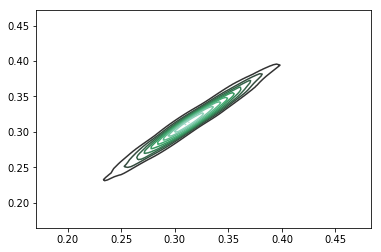

In [101]:
sns.kdeplot(samples[:,10,2,0], samples[:,11,2,0])
plt.show()

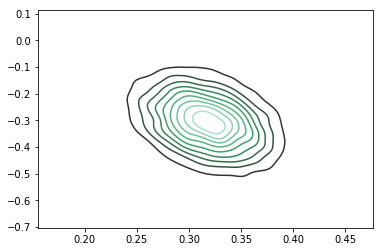

In [71]:
sns.kdeplot(samples[:,5,2,0], samples[:,5,0,0])
plt.show()

In [72]:
t = 14
# params[t]

In [73]:
np.mean(samples[:,t], axis=0)

array([[-0.2966, -0.0355, -0.1499, -1.226 ],
       [ 0.065 ,  0.213 ,  0.6113,  0.2153],
       [ 0.3156, -0.0395,  0.8528,  0.8874]])

In [74]:
np.std(samples[:,t], axis=0)

array([[0.1313, 0.1143, 0.13  , 0.2039],
       [0.1237, 0.1299, 0.1378, 0.1053],
       [0.0404, 0.0255, 0.0468, 0.2067]])

In [52]:
from scipy.stats import normaltest

In [64]:
tt = samples[:,1,0,0] + samples[:,0,0,0]

In [65]:
normaltest(tt)

NormaltestResult(statistic=0.14859962466486085, pvalue=0.9283933083484818)

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


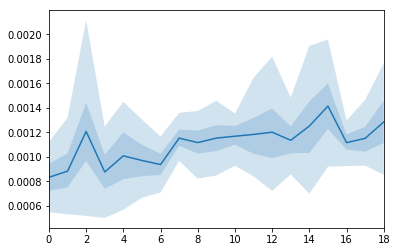

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


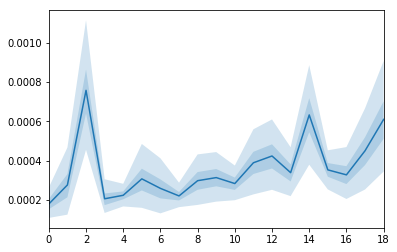

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


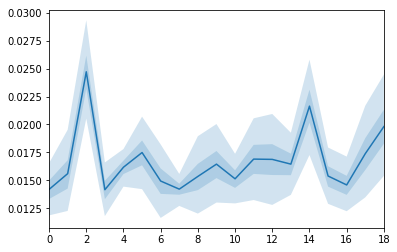

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()